In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
 
import matplotlib.pyplot as plt
import numpy as np
import os

import torch 
import utils 


In [2]:
path = "./out/pipeline_results/gt_boxes_middle_sam1_b_coco_val_60_08_26"
results, config, array_boxes, array_masks = utils.load_results(path)

{'batchsize': 6,
 'dataset': {'name': 'coco', 'split': 'val', 'year': '2017'},
 'detector': {'name': 'gt_boxes_middle'},
 'max_batch': 10,
 'print_results': True,
 'save_path': './out/pipeline_results/',
 'save_results': True,
 'segmentation': {'model': 'b', 'name': 'sam1'}}


In [19]:
IoU_array = array_masks
print(np.mean(IoU_array))
print(np.median(IoU_array))

0.7327697
0.783071


In [28]:
thr=0.25
print(np.sum(IoU_array >= thr) / len(IoU_array))

0.9826086956521739


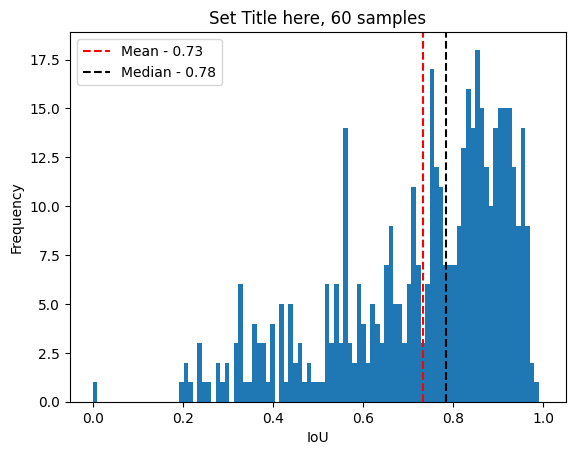

In [27]:
lspace = np.linspace(0.0, 1.0, 100)

# Calculate the number of objects in each bin
hist, bins, _ = plt.hist(IoU_array, bins=lspace)

# Find the bin index where the mean value of IoU_array falls
mean_threshold = np.mean(IoU_array)
median_threshold = np.median(IoU_array)
plt.axvline(x=mean_threshold, color="red", linestyle="--")
plt.axvline(x=median_threshold, color="black", linestyle="--")
# Add labels and title
plt.xlabel("IoU")
plt.ylabel("Frequency")
size = (config["max_batch"] * config["batchsize"])
plt.title(f"Set Title here, {size} samples")

mean = "{:.2f}".format(mean_threshold)
median = "{:.2f}".format(median_threshold)
plt.legend([f"Mean - {mean}", f"Median - {median}"])
# Show the plot
plt.show()

### Comparison


In [2]:
path1 = "./out/pipeline_results/gt_boxes_middle_sam1_b_coco_val_600_08_26"
_, _, array_boxes1, array_masks1 = utils.load_results(path1)

In [4]:
path2 = "./out/pipeline_results/gt_boxes_sam1_b_coco_val_600_08_26"
_, config2, array_boxes2, array_masks2 = utils.load_results(path2)

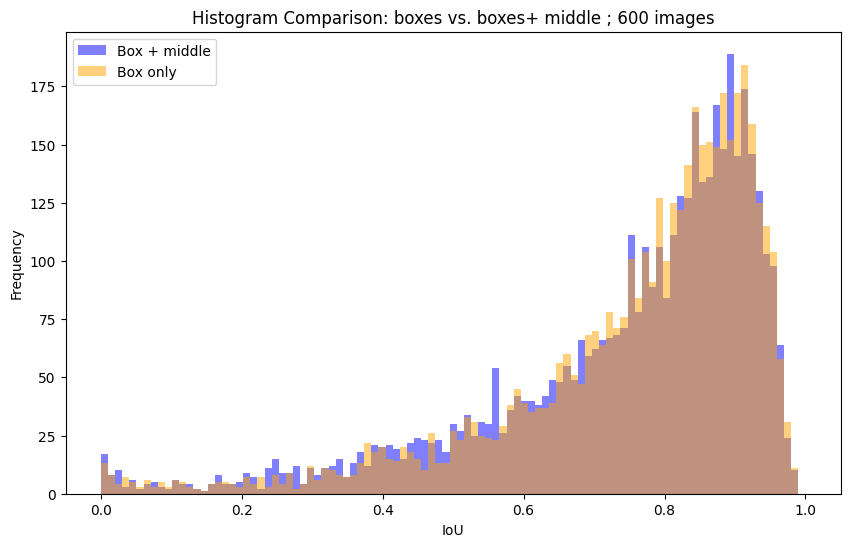

In [5]:
# put 2 arrays of IoUs here, here is an example with masks and boxes, not important
first = array_masks1
second = array_masks2

plt.figure(figsize=(10, 6))

# Plot the "large" histogram
bins = np.linspace(0, 1, 100)
plt.hist(first, bins=bins, alpha=0.5, label="Box + middle", color="blue")

# Plot the "base" histogram
plt.hist(second, bins=bins, alpha=0.5, label='Box only', color='orange')

# Add labels and title
plt.xlabel('IoU')
plt.ylabel('Frequency')
size = config2["max_batch"] * config2["batchsize"]
plt.title(f"Histogram Comparison: boxes vs. boxes+ middle ; {size} images")

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
#load the same sam and detector, produce box and mask to visualise. 
# otherwise Im not sure what to do with this
for i in range(len(array_masks2)):
    if array_masks2[i] < 0.1:
        print(array_masks2[i])